In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline 

In [47]:
test.columns.values

array(['product_id', 'up_orders', 'up_first_order', 'up_last_order',
       'up_average_cart_position', 'prod_orders',
       'prod_reorder_probability', 'prod_reorder_ratio', 'user_orders',
       'user_period', 'user_mean_days_since_prior', 'user_total_products',
       'user_reorder_ratio', 'user_distinct_products',
       'user_average_basket', 'order_id', 'days_since_prior_order',
       'up_order_rate', 'up_orders_since_last_order', 'aisle_id',
       'department_id'], dtype=object)

In [2]:
loc = ''
print('read files')

prior = pd.read_csv(loc + 'order_products__prior.csv', 
                    dtype={'order_id': np.uint32,
                           'product_id': np.uint16, 
                           'reordered': np.uint8, 
                           'add_to_cart_order': np.uint8})

train_orders = pd.read_csv(loc + 'order_products__train.csv', 
                    dtype={'order_id': np.uint32,
                           'product_id': np.uint16, 
                           'reordered': np.int8, 
                           'add_to_cart_order': np.uint8 })

orders = pd.read_csv(loc + 'orders.csv', 
                    dtype={'order_hour_of_day': np.uint8,
                           'order_number': np.uint8, 
                           'order_id': np.uint32, 
                           'user_id': np.uint32,
                           'order_dow': np.uint8, 
                           'days_since_prior_order': np.float16})

products = pd.read_csv(loc + 'products.csv', 
                    dtype={'product_id': np.uint16,
                           'aisle_id': np.uint8, 'department_id': np.uint8},
                    usecols=['product_id', 'aisle_id', 'department_id'])

orders.eval_set = orders.eval_set.replace({'prior': 0, 'train': 1, 'test':2}).astype(np.uint8)
orders.days_since_prior_order = orders.days_since_prior_order.fillna(30).astype(np.uint8)
print('tables uploaded')



print('merge prior and orders and keep train separate ...')
orders_products = orders.merge(prior, how = 'inner', on = 'order_id')
train_orders = train_orders.merge(orders[['user_id','order_id']], left_on = 'order_id', right_on = 'order_id', how = 'inner')


gc.collect()

read files
tables uploaded
merge prior and orders and keep train separate ...


28

In [58]:
users

,user_id,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_reorder_ratio,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order
0,1,10,206.0,20.600000,59,0.759259,18,5.900000,1187899,1,14
1,2,14,228.0,16.285714,195,0.510989,102,13.928571,1492625,1,30
2,3,12,163.0,13.583333,88,0.705128,33,7.333333,2774568,2,11
3,4,5,85.0,17.000000,18,0.071429,17,3.600000,329954,2,30
4,5,4,70.0,17.500000,37,0.538462,23,9.250000,2196797,1,6
5,6,3,48.0,16.000000,14,0.200000,12,4.666667,1528013,2,22
6,7,20,233.0,11.650000,206,0.711340,68,10.300000,525192,1,6
7,8,3,90.0,30.000000,49,0.464286,36,16.333333,880375,1,10
8,9,3,66.0,22.000000,76,0.391304,58,25.333333,1094988,1,30
9,10,5,109.0,21.800000,143,0.355072,94,28.600000,1822501,1,30


In [3]:
print('Creating features I ...')

# sort orders and products to get the rank or the reorder frequency
prdss = orders_products.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
prdss['product_time'] = prdss.groupby(['user_id', 'product_id']).cumcount()+1

# getting products ordered first and second times to calculate probability later
sub1 = prdss[prdss['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prdss[prdss['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')
sub1['prod_orders'] = prdss.groupby('product_id')['product_id'].size()
sub1['prod_reorders'] = prdss.groupby('product_id')['reordered'].sum()
sub2 = sub2.reset_index().merge(sub1.reset_index())
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']
prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]

del sub1, sub2, prdss
gc.collect()

Creating features I ...


196

In [66]:
len(users)

206209

In [4]:
print('Creating features II ...')

# extracting prior information (features) by user
users = orders[orders['eval_set'] == 0].groupby(['user_id'])['order_number'].max().to_frame('user_orders')
users['user_period'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].sum()
users['user_mean_days_since_prior'] = orders[orders['eval_set'] == 0].groupby(['user_id'])['days_since_prior_order'].mean()

# merging features about users and orders into one dataset
us = orders_products.groupby('user_id').size().to_frame('user_total_products')
us['eq_1'] = orders_products[orders_products['reordered'] == 1].groupby('user_id')['product_id'].size()
us['gt_1'] = orders_products[orders_products['order_number'] > 1].groupby('user_id')['product_id'].size()
us['user_reorder_ratio'] = us['eq_1'] / us['gt_1']
us.drop(['eq_1', 'gt_1'], axis = 1, inplace = True)
us['user_distinct_products'] = orders_products.groupby(['user_id'])['product_id'].nunique()

# the average basket size of the user
users = users.reset_index().merge(us.reset_index())
users['user_average_basket'] = users['user_total_products'] / users['user_orders']

us = orders[orders['eval_set'] != 0]
us = us[['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
users = users.merge(us)

del us
gc.collect()





print('Finalizing features and the main data file  ...')
# merging orders and products and grouping by user and product and calculating features for the user/product combination
data = orders_products.groupby(['user_id', 'product_id']).size().to_frame('up_orders')
data['up_first_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].min()
data['up_last_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].max()
data['up_average_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()
data = data.reset_index()

#merging previous data with users
data = data.merge(prd, on = 'product_id')
data = data.merge(users, on = 'user_id')

#user/product combination features about the particular order
data['up_order_rate'] = data['up_orders'] / data['user_orders']
data['up_orders_since_last_order'] = data['user_orders'] - data['up_last_order']
data = data.merge(train_orders[['user_id', 'product_id', 'reordered']], 
                  how = 'left', on = ['user_id', 'product_id'])
data = data.merge(products, on = 'product_id')

del orders_products     #, orders, train_orders
gc.collect()






print(' Training and test data for later use in F1 optimization and training  ...')

#save the actual reordered products of the train set in a list format and then delete the original frames
train_orders = train_orders[train_orders['reordered']==1].drop('reordered',axis=1)
orders.set_index('order_id', drop=False, inplace=True)
train1=orders[['order_id','eval_set']].loc[orders['eval_set']==1]
train1['actual'] = train_orders.groupby('order_id').aggregate({'product_id':lambda x: list(x)})
train1['actual']=train1['actual'].fillna('')
n_actual = train1['actual'].apply(lambda x: len(x)).mean()   # this is the average cart size

test1=orders[['order_id','eval_set']].loc[orders['eval_set']==2]
test1['actual']=' '
traintest1=pd.concat([train1,test1])
traintest1.set_index('order_id', drop=False, inplace=True)

del orders, train_orders, train1, test1
gc.collect()






print('setting dtypes for data ...')

#reduce the size by setting data types
data = data.astype(dtype= {'user_id' : np.uint32, 'product_id'  : np.uint16,
            'up_orders'  : np.uint8, 'up_first_order' : np.uint8, 'up_last_order' : np.uint8,
            'up_average_cart_position' : np.uint8, 'prod_orders' : np.uint16, 
            'prod_reorder_probability' : np.float16,   
            'prod_reorder_ratio' : np.float16, 'user_orders' : np.uint8,
            'user_period' : np.uint8, 'user_mean_days_since_prior' : np.uint8,
            'user_total_products' : np.uint8, 'user_reorder_ratio' : np.float16, 
            'user_distinct_products' : np.uint8, 'user_average_basket' : np.uint8,
            'order_id'  : np.uint32, 'eval_set' : np.uint8, 
            'days_since_prior_order' : np.uint8, 'up_order_rate' : np.float16, 
            'up_orders_since_last_order':np.uint8,
            'aisle_id': np.uint8, 'department_id': np.uint8})

data['reordered'].fillna(0, inplace=True)  # replace NaN with zeros (not reordered) 
data['reordered']=data['reordered'].astype(np.uint8)

gc.collect()









print('Preparing Train and Test sets ...')

# filter by eval_set (train=1, test=2) and dropp the id's columns (not part of training features) 
# but keep prod_id and user_id in test

train = data[data['eval_set'] == 1].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1)
test =  data[data['eval_set'] == 2].drop(['eval_set', 'user_id', 'reordered'], axis = 1)

check =  data.drop(['eval_set', 'user_id', 'reordered'], axis = 1)

#del data
gc.collect()





print('preparing X,y for LightGBM ...')

# for preliminary runs sample a fraction of the data by (un)commenting the next two lines
#print('sampling train data ...')
#train = train.sample(frac=0.25)

# Splitting the training set to train and validation set
X_train, X_eval, y_train, y_eval = train_test_split(
    train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.1, random_state=2)

del train
gc.collect()

Creating features II ...


123

Finalizing features and the main data file  ...


147

 Training and test data for later use in F1 optimization and training  ...


45

setting dtypes for data ...


7

Preparing Train and Test sets ...


0

preparing X,y for LightGBM ...


51

In [5]:
feature_descriptions=[
    'aisle id',
    'number of days after last prior order that occurred before train/test order was bought',
    'department id',
    'across all users, number of product j bought',
    'across all users, probability of product j being re-ordered',
    'across all users, percentage of product j being re-ordered',
    'for a user/product, average position of product in the order for that user',
    'for a user/product, first order for user in which product is bought',
    'for a user/product, last order for user in which product is bought',
    'for a user/product, average number of product per order for user (total number of product j / total orders)',
    'user\'s total number of product j bought',
    'user\'s number of orders that occurred since the order in which product j was last ordered',
    'user\'s average number of items bought',
    'user\'s distinct number of items bought',
    'user\'s average number of days between orders containing product',
    'user\'s total number of orders',
    'user\'s total number of days spent making all prior orders',
    'user\'s number of reordered products divided by total products that could have been re-ordered',
    'user\'s total number of products bought across all orders'

]

In [6]:
desc=pd.DataFrame({'Feature Descriptions':feature_descriptions\
                  ,'Features':X_train.columns.tolist()})
desc=desc.set_index('Features')
pd.set_option('display.max_colwidth', -1)
desc

,Feature Descriptions
Features,
aisle_id,aisle id
days_since_prior_order,number of days after last prior order that occurred before train/test order was bought
department_id,department id
prod_orders,"across all users, number of product j bought"
prod_reorder_probability,"across all users, probability of product j being re-ordered"
prod_reorder_ratio,"across all users, percentage of product j being re-ordered"
up_average_cart_position,"for a user/product, average position of product in the order for that user"
up_first_order,"for a user/product, first order for user in which product is bought"
up_last_order,"for a user/product, last order for user in which product is bought"


# Pickle the data

In [7]:
df=[X_train,X_eval,y_train,y_eval,test,data]
o = open('LB3.pkl','wb') 
pickle.dump(df,o)   
o.close()

# Load the data

In [14]:
o = open('LB3.pkl','rb') 
df = pickle.load(o)  
o.close()
X_train,X_eval,y_train,y_eval,test,data=df

# Remove the nulls (about 28,000 observations...)

In [10]:
X_train.isnull().values.any()

True

In [11]:
for j in np.asarray(X_train.columns):
    if X_train[j].isnull().values.any()==True:
        print(j)

user_reorder_ratio


In [13]:
nulls_train=X_train[X_train['user_reorder_ratio'].isnull()].index.values
X_train=X_train.drop(nulls_train)
y_train=y_train.drop(nulls_train)

nulls_eval=X_eval[X_eval['user_reorder_ratio'].isnull()].index.values
X_eval=X_eval.drop(nulls_eval)
y_eval=y_eval.drop(nulls_eval)

# Scale data for certain models

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_eval_scaled = scaler.transform(X_eval)
#http://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2
#normalize data before sending through an NN

# Preparing the test data

In [15]:
#set nulls to mean value
#standardize
x_test=test.astype('float').fillna('mean')
x_test2=x_test.drop(['order_id','product_id'],axis=1)
x_test2=x_test2[x_test2.columns.sort_values()]
X_train=X_train[X_train.columns.sort_values()]
X_train.columns==x_test2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [24]:
for j in range(len(x_test2.columns)):
    if X_train.iloc[:,j].dtype=='uint8':
        x_test2.iloc[:,j]=x_test2.iloc[:,j].astype('uint8')
    elif X_train.iloc[:,j].dtype=='uint16':
        x_test2.iloc[:,j]=x_test2.iloc[:,j].astype('uint16')

In [28]:
x_test2['user_reorder_ratio'].astype('float16')

ValueError: could not convert string to float: mean

In [27]:
x_test=scaler.transform(x_test2)

ValueError: could not convert string to float: mean

In [16]:
for j in np.asarray(x_test.columns):
    if x_test[j].isnull().values.any()==True:
        print(j)

# Exploratory Data Analysis

In [15]:
# departments
departments = pd.read_csv('instacart/departments.csv', engine='c')
print('Total departments: {}'.format(departments.shape[0]))


# aisles
aisles = pd.read_csv('instacart/aisles.csv', engine='c')
print('Total aisles: {}'.format(aisles.shape[0]))

# products
product_names = pd.read_csv('instacart/products.csv', engine='c')
print('Total products: {}'.format(product_names.shape[0]))
product_names.head(5)

# combine aisles, departments and products (left joined to products)
goods = pd.merge(left=pd.merge(left=product_names, right=departments, how='left'), right=aisles, how='left')
# to retain '-' and make product names more "standard"
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 

goods.head()

Total departments: 21
Total aisles: 134
Total products: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13


,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies cakes
1,2,all-seasons_salt,104,13,pantry,spices seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_with_vodka_cream_sauce,38,1,frozen,frozen meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades meat preparation


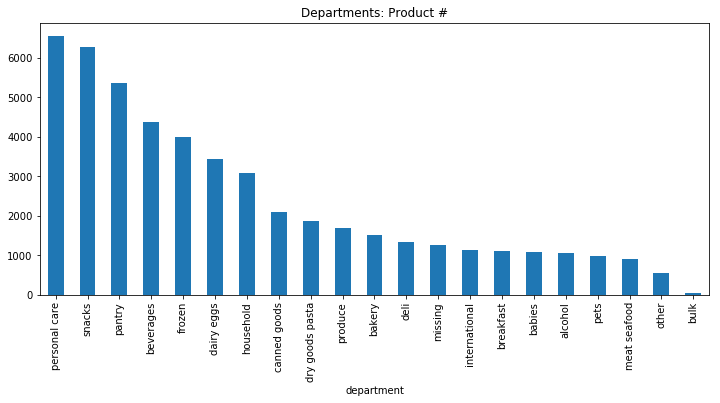

In [17]:
# basic group info (departments)
plt.figure(figsize=(12, 5))
goods.groupby(['department']).count()['product_id'].copy()\
.sort_values(ascending=False).plot(kind='bar', 
                                   #figsize=(12, 5), 
                                   title='Departments: Product #')

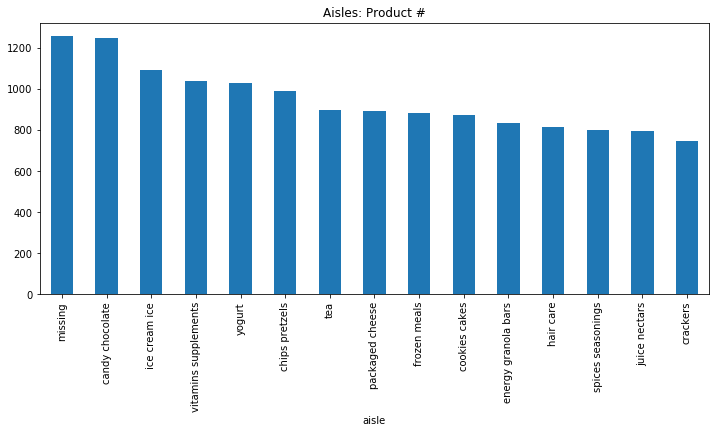

In [18]:
# basic group info (top-x aisles)
top_aisles_cnt = 15
plt.figure(figsize=(12, 5))
goods.groupby(['aisle']).count()['product_id']\
.sort_values(ascending=False)[:top_aisles_cnt].plot(kind='bar', 
                                   #figsize=(12, 5), 
                                   title='Aisles: Product #')

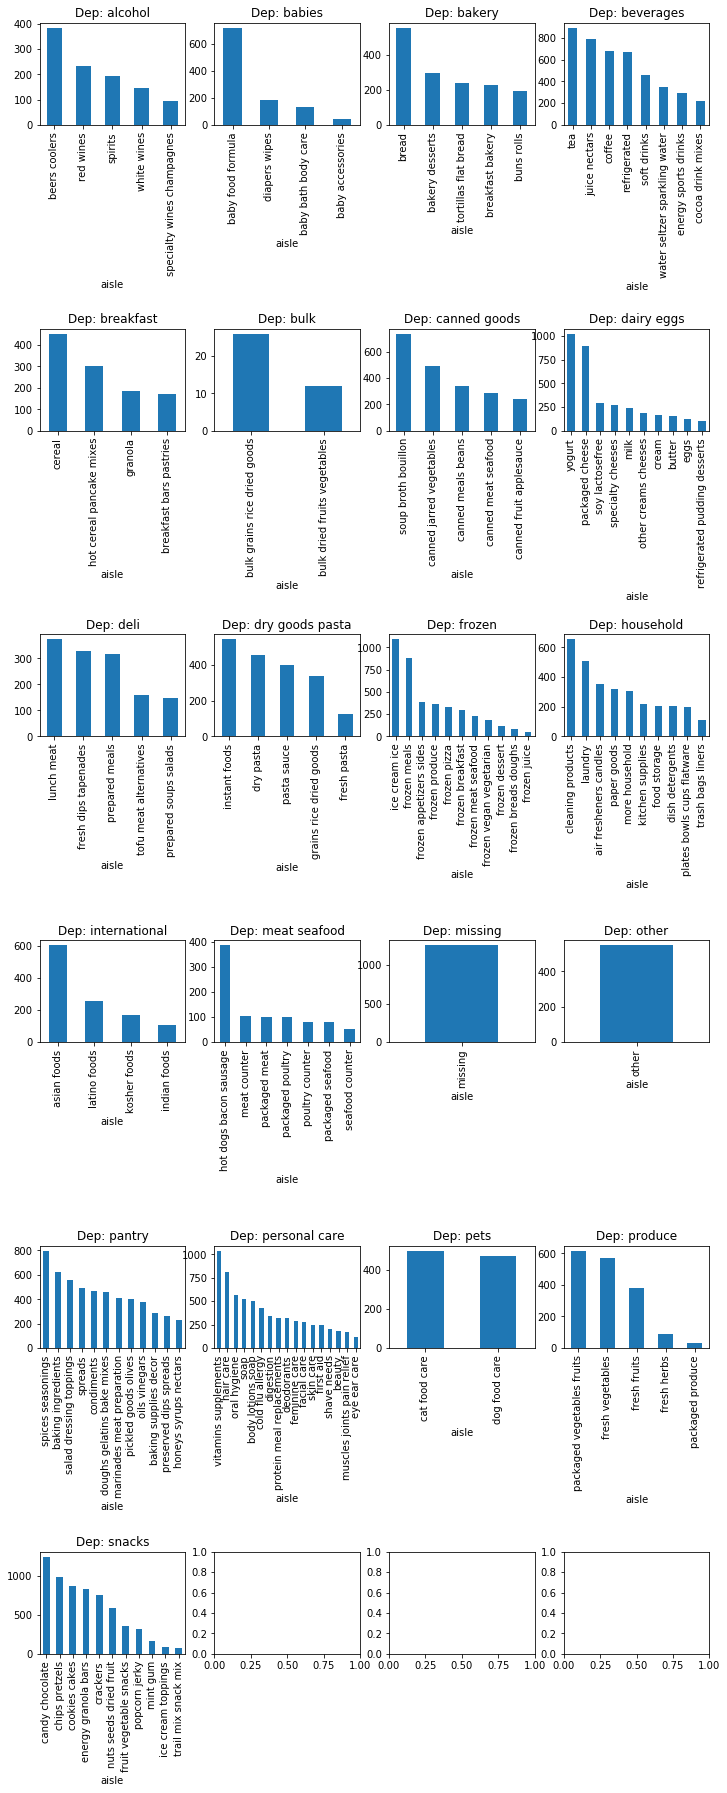

In [20]:

# plot departments volume, split by aisles
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    goods[goods.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

In [26]:
op_train = pd.read_csv('instacart/order_products__train.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
op_prior = pd.read_csv('instacart/order_products__prior.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
orders = pd.read_csv('instacart/orders.csv', engine='c', dtype={'order_id': np.int32, 
                                                           'user_id': np.int32, 
                                                           'order_number': np.int32, 
                                                           'order_dow': np.int8, 
                                                           'order_hour_of_day': np.int8, 
                                                           'days_since_prior_order': np.float16})


Total ordered products(train): 1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [33]:
data2=pd.merge(left=data,right=goods,on='product_id')

In [36]:
data2.columns

Index([u'user_id', u'product_id', u'up_orders', u'up_first_order',
       u'up_last_order', u'up_average_cart_position', u'prod_orders',
       u'prod_reorder_probability', u'prod_reorder_ratio', u'user_orders',
       u'user_period', u'user_mean_days_since_prior', u'user_total_products',
       u'user_reorder_ratio', u'user_distinct_products',
       u'user_average_basket', u'order_id', u'eval_set',
       u'days_since_prior_order', u'up_order_rate',
       u'up_orders_since_last_order', u'reordered', u'aisle_id_x',
       u'department_id_x', u'product_name', u'aisle_id_y', u'department_id_y',
       u'department', u'aisle'],
      dtype='object')

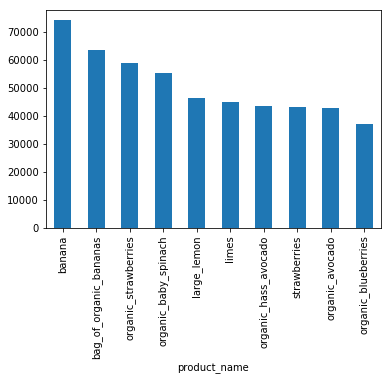

In [48]:
#want count of orders with product, and product on x
temp=data2.groupby('product_name').order_id.size().sort_values(ascending=False)[:10]
temp.plot(kind='bar')

In [95]:
len(data.columns)

24

In [93]:
data2

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_ratio,user_orders,...,up_order_rate,up_orders_since_last_order,reordered,aisle_id_x,department_id_x,product_name,aisle_id_y,department_id_y,department,aisle
0,1,196,10,1,10,1,35791,0.582520,0.776367,10,...,1.000000,0,1,77,7,soda,77,7,beverages,soft drinks
1,15,196,5,15,22,2,35791,0.582520,0.776367,22,...,0.227295,0,0,77,7,soda,77,7,beverages,soft drinks
2,19,196,3,2,7,6,35791,0.582520,0.776367,9,...,0.333252,2,0,77,7,soda,77,7,beverages,soft drinks
3,21,196,1,10,10,2,35791,0.582520,0.776367,33,...,0.030304,23,0,77,7,soda,77,7,beverages,soft drinks
4,31,196,2,10,17,15,35791,0.582520,0.776367,20,...,0.099976,3,0,77,7,soda,77,7,beverages,soft drinks
5,43,196,2,6,9,5,35791,0.582520,0.776367,11,...,0.181763,2,0,77,7,soda,77,7,beverages,soft drinks
6,52,196,14,1,21,4,35791,0.582520,0.776367,27,...,0.518555,6,0,77,7,soda,77,7,beverages,soft drinks
7,67,196,19,1,23,1,35791,0.582520,0.776367,24,...,0.791504,1,1,77,7,soda,77,7,beverages,soft drinks
8,81,196,2,3,5,1,35791,0.582520,0.776367,7,...,0.285645,2,0,77,7,soda,77,7,beverages,soft drinks
9,82,196,9,1,19,2,35791,0.582520,0.776367,19,...,0.473633,0,0,77,7,soda,77,7,beverages,soft drinks


In [87]:
temp=data2.groupby(['order_id']).up_orders.sum()
temp=temp.reset_index()
temp.columns=['order_id','up_orders']
temp=temp.groupby(['up_orders']).order_id.size()

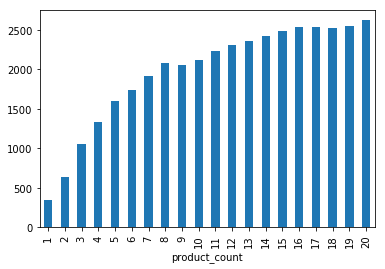

In [77]:
temp[:20].plot(kind='bar')

In [ ]:
# combine aisles, departments and products (left joined to products)
goods = pd.merge(left=pd.merge(left=product_names, right=departments, how='left'), right=aisles, how='left')
# to retain '-' and make product names more "standard"
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 

goods.head()

# Light GBM

In [8]:
print('formatting and training LightGBM ...')

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

# there is some room to change the parameters and improve - I have not done it systematically

params = {'task': 'train', 'boosting_type': 'gbdt',   'objective': 'binary', 'metric': {'binary_logloss', 'auc'},
    'num_iterations' : 1000, 'max_bin' : 100, 'num_leaves': 512, 'feature_fraction': 0.8,  'bagging_fraction': 0.95,
    'bagging_freq': 5, 'min_data_in_leaf' : 200, 'learning_rate' : 0.05}

# set lower num_boost_round (I used 300 instead of 50 at home) to avoid time-out on Kaggle

lgb_model = lgb.train(params, lgb_train, num_boost_round = 50, valid_sets = lgb_eval, early_stopping_rounds=10)

del lgb_train, X_train, y_train
gc.collect()

formatting and training LightGBM ...
[1]	valid_0's auc: 0.81559	valid_0's binary_logloss: 0.658631
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.825327	valid_0's binary_logloss: 0.627158
[3]	valid_0's auc: 0.824417	valid_0's binary_logloss: 0.59879
[4]	valid_0's auc: 0.826322	valid_0's binary_logloss: 0.572725
[5]	valid_0's auc: 0.827338	valid_0's binary_logloss: 0.548873
[6]	valid_0's auc: 0.827759	valid_0's binary_logloss: 0.5271
[7]	valid_0's auc: 0.82824	valid_0's binary_logloss: 0.507085
[8]	valid_0's auc: 0.828362	valid_0's binary_logloss: 0.488696
[9]	valid_0's auc: 0.828753	valid_0's binary_logloss: 0.471663
[10]	valid_0's auc: 0.828868	valid_0's binary_logloss: 0.455996
[11]	valid_0's auc: 0.828727	valid_0's binary_logloss: 0.44162
[12]	valid_0's auc: 0.828971	valid_0's binary_logloss: 0.428167
[13]	valid_0's auc: 0.829176	valid_0's binary_logloss: 0.415699
[14]	valid_0's auc: 0.829261	valid_0's binary_logloss: 0.40413
[15]	valid_0's auc: 0

59

In [9]:
# Define an auxiliary function to combine the product data into orders

def combi(z,df):
    
    prd_bag = dict()
    z_bag = dict()
    for row in df.itertuples():
        if row.reordered > z:   
            try:
                prd_bag[row.order_id] += ' ' + str(row.product_id)
                z_bag[row.order_id]+= ' ' + str(int(100*row.reordered))
            except:
                prd_bag[row.order_id] = str(row.product_id)
                z_bag[row.order_id]= str(int(100*row.reordered))

    for order in df.order_id:
        if order not in prd_bag:
            prd_bag[order] = ' '
            z_bag[order] = ' '

    return prd_bag,z_bag 

# F1 function uses the actual products as a list in the train set and the list of predicted products

def f1_score_single(x):                 #from LiLi but modified to get 1 for both empty

    y_true = x.actual
    y_pred = x.list_prod
    if y_true == '' and y_pred ==[] : return 1.
    y_true = set(y_true)
    y_pred = set(y_pred)
    cross_size = len(y_true & y_pred)
    if cross_size == 0: return 0.
    p = 1. * cross_size / len(y_pred)
    r = 1. * cross_size / len(y_true)
    return 2 * p * r / (p + r)

In [10]:
print(' Applying model to all data - both train and test ')
check['reordered'] = lgb_model.predict(check[check.columns.difference(
    ['order_id', 'product_id'])], num_iteration = lgb_model.best_iteration)
gc.collect()

 Applying model to all data - both train and test 


29

In [11]:
print(' summarizing products and probabilities ...')

# get the prediction for a range of thresholds

tt=traintest1.copy()
i=0

for z in [0.17, 0.21, 0.25]:
    
    prd_bag,z_bag = combi(z,check)
    ptemp = pd.DataFrame.from_dict(prd_bag, orient='index')
    ptemp.reset_index(inplace=True)
    ztemp = pd.DataFrame.from_dict(z_bag, orient='index')
    ztemp.reset_index(inplace=True)
    ptemp.columns = ['order_id', 'products']
    ztemp.columns = ['order_id', 'zs']
    ptemp['list_prod'] = ptemp['products'].apply(lambda x: list(map(int, x.split())))
    ztemp['list_z'] = ztemp['zs'].apply(lambda x: list(map(int, x.split())))
    n_cart = ptemp['products'].apply(lambda x: len(x.split())).mean()
    tt = tt.merge(ptemp,on='order_id',how='inner')
    tt = tt.merge(ztemp,on='order_id',how='inner')
    tt.drop(['products','zs'],axis=1,inplace=True)
    tt['zavg'] = tt['list_z'].apply(lambda x: 0.01*np.mean(x) if x!=[] else 0.).astype(np.float16)
    tt['zmax'] = tt['list_z'].apply(lambda x: 0.01*np.max(x) if x!=[] else 0.).astype(np.float16)
    tt['zmin'] = tt['list_z'].apply(lambda x: 0.01*np.min(x) if x!=[] else 0.).astype(np.float16)
    tt['f1']=tt.apply(f1_score_single,axis=1).astype(np.float16)
    F1 = tt['f1'].loc[tt['eval_set']==1].mean()
    tt = tt.rename(columns={'list_prod': 'prod'+str(i), 'f1': 'f1'+str(i), 'list_z': 'z'+str(i),
                'zavg': 'zavg'+str(i), 'zmax': 'zmax'+str(i),  'zmin': 'zmin'+str(i)})
    print(' z,F1,n_actual,n_cart :  ', z,F1,n_actual,n_cart)
    i=i+1

tt['fm'] = tt[['f10', 'f11', 'f12']].idxmax(axis=1)
tt['f1'] = tt[['f10', 'f11', 'f12']].max(axis=1)
tt['fm'] = tt.fm.replace({'f10': 0,'f11': 1, 'f12':2}).astype(np.uint8)
print(' f1 maximized ', tt['f1'].loc[tt['eval_set']==1].mean())
    
del prd_bag, z_bag, ptemp, ztemp
gc.collect()

 summarizing products and probabilities ...
 z,F1,n_actual,n_cart :   0.17 0.37085 6.316822778925226 13.086630554437487
 z,F1,n_actual,n_cart :   0.21 0.38062 6.316822778925226 9.684169944085856
 z,F1,n_actual,n_cart :   0.25 0.37842 6.316822778925226 7.418793554112575
 f1 maximized  0.44019


111

In [17]:
tt.head(2)

,order_id,eval_set,actual,prod0,z0,zavg0,zmax0,zmin0,f10,prod1,...,zmin1,f11,prod2,z2,zavg2,zmax2,zmin2,f12,fm,f1
0,1187899,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032, 26088, 49235, 46149]","[196, 10258, 12427, 13032, 25133, 35951, 38928, 39657, 46149, 49235]","[82, 75, 80, 33, 69, 32, 34, 33, 59, 29]",0.525879,0.819824,0.290039,0.799805,"[196, 10258, 12427, 13032, 25133, 35951, 38928, 39657, 46149, 49235]",...,0.290039,0.799805,"[196, 10258, 12427, 13032, 25133, 35951, 38928, 39657, 46149, 49235]","[82, 75, 80, 33, 69, 32, 34, 33, 59, 29]",0.525879,0.819824,0.290039,0.799805,0,0.799805
1,1492625,1,"[22963, 7963, 16589, 32792, 41787, 22825, 24852, 45066, 5450, 22559, 45613, 33957]","[18523, 24852, 33754, 47209, 21709, 7781, 1559, 22825, 39928, 19156, 22124, 16589, 32792, 32139]","[45, 49, 41, 51, 30, 27, 42, 17, 17, 40, 22, 36, 31, 17]",0.332031,0.509766,0.170044,0.307617,"[18523, 24852, 33754, 47209, 21709, 7781, 1559, 19156, 22124, 16589, 32792]",...,0.219971,0.260986,"[18523, 24852, 33754, 47209, 21709, 7781, 1559, 19156, 16589, 32792]","[45, 49, 41, 51, 30, 27, 42, 40, 36, 31]",0.392090,0.509766,0.270020,0.272705,0,0.307617


In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

print('Fitting the second classifier for F1 ...')

X=tt[[ 'zavg0', 'zmax0','zmin0', 'zavg1', 'zmax1', 'zmin1', 'zavg2', 'zmax2', 'zmin2']].loc[tt['eval_set']==1]
y=tt['fm'].loc[tt['eval_set']==1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = GradientBoostingClassifier().fit(X_train, y_train)
print('GB Accuracy on training set: {:.2f}' .format(clf.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}' .format(clf.score(X_test, y_test)))
#pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=["Importance"]).plot(kind='bar')
#plt.show()

final=tt[['order_id','prod0','prod1','prod2','zavg0']].loc[tt['eval_set']==2]
df_test=tt[[ 'zavg0', 'zmax0','zmin0', 'zavg1', 'zmax1', 'zmin1', 'zavg2', 'zmax2', 'zmin2']].loc[tt['eval_set']==2]
final['fit']= clf.predict(df_test)
final['best'] = final.apply(lambda row: row['prod0'] if row['fit']==0 else 
                                 ( row['prod1'] if row['fit']==1 else  row['prod2'] )  , axis=1)

#final['products']=final['best'].apply(lambda x: ' '.join(str(i) for i in x) if x!=[] else 'None')

# I am adding 'None' to orders with one or two products because of the bias in F1

def mylist(x):
    prodids = x.best
    zavg = x.zavg0
    if prodids == []: return 'None'            
    if zavg < 0.5:
        if len(prodids) == 1: return  str(prodids[0])+' None'
        if len(prodids) == 2: return  str(prodids[0])+ ' '+ str(prodids[1]) +' None'
    return ' '.join(str(i) for i in prodids)

final['products']=final.apply(mylist,axis=1)

final[['order_id','products']].to_csv('final_submission1.csv', index=False)  

gc.collect()

Fitting the second classifier for F1 ...
GB Accuracy on training set: 0.57
Accuracy on test set: 0.56


14

In [21]:
X

array([ 0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19,  0.2 ,
        0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,  0.28,  0.29,  0.3 ])

In [23]:
y[:5]

0    0
1    0
2    0
3    1
4    1
Name: fm, dtype: uint8

In [25]:
df_test.head()

,zavg0,zmax0,zmin0,zavg1,zmax1,zmin1,zavg2,zmax2,zmin2
131209,0.382080,0.680176,0.180054,0.431152,0.680176,0.239990,0.458496,0.680176,0.260010
131210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
131211,0.256592,0.409912,0.170044,0.326660,0.409912,0.209961,0.385010,0.409912,0.360107
131212,0.284424,0.489990,0.170044,0.328125,0.489990,0.229980,0.348877,0.489990,0.250000
131213,0.272949,0.509766,0.170044,0.312744,0.509766,0.219971,0.375000,0.509766,0.290039


In [19]:
final.head()

,order_id,prod0,prod1,prod2,zavg0,fit,best,products
131209,2774568,"[47766, 24810, 16797, 43961, 18599, 39190, 21903, 17668, 32402, 23650]","[47766, 24810, 43961, 18599, 39190, 21903, 17668, 23650]","[47766, 43961, 18599, 39190, 21903, 17668, 23650]",0.382080,2,"[47766, 43961, 18599, 39190, 21903, 17668, 23650]",47766 43961 18599 39190 21903 17668 23650
131210,329954,[],[],[],0.000000,0,[],None
131211,1528013,"[8424, 38293, 45007, 21903, 27521, 48679]","[8424, 38293, 21903]","[38293, 21903]",0.256592,0,"[8424, 38293, 45007, 21903, 27521, 48679]",8424 38293 45007 21903 27521 48679
131212,1376945,"[13176, 24799, 28465, 44632, 17794, 35948, 14947, 49374, 17706, 27959, 8309, 20383, 33572, 34658, 4799, 30563]","[13176, 24799, 28465, 44632, 35948, 14947, 17706, 27959, 8309, 33572, 34658]","[13176, 24799, 28465, 44632, 14947, 27959, 8309, 33572, 34658]",0.284424,2,"[13176, 24799, 28465, 44632, 14947, 27959, 8309, 33572, 34658]",13176 24799 28465 44632 14947 27959 8309 33572 34658
131213,1356845,"[13176, 14992, 22959, 49683, 30489, 21616, 7076, 11520, 10863, 28134]","[13176, 14992, 21616, 7076, 11520, 10863, 28134]","[13176, 14992, 7076, 10863]",0.272949,0,"[13176, 14992, 22959, 49683, 30489, 21616, 7076, 11520, 10863, 28134]",13176 14992 22959 49683 30489 21616 7076 11520 10863 28134


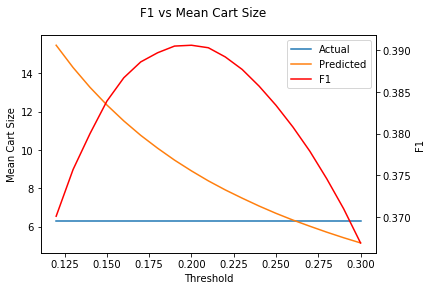

In [13]:
#I saved one of the previous runs so that it is not timed out on Kaggle
X=np.arange(0.12,0.31,0.01)
Y2 = np.empty(19)
Y2.fill(6.31)
Y1=[ 0.3701,0.3757,0.38,0.3839,0.3867,0.3886,0.3897,0.3905,0.3906,0.3903,
    0.3892,0.3877,0.3857,0.3834,0.3808,0.3779,0.3746,0.371,0.3669]
Y3=[ 15.45,14.29,13.26,12.34,11.51,10.76,10.09,9.47,8.91,8.39,7.92,7.49,
    7.08,6.7,6.35,6.03,5.72,5.43,5.16]
#replace X,Y1,Y2,Y3 with arrays from z,F1,n_actual,n_cart to update (running the above cell for the corresponding rane of z's)

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot(X, Y2, '-', label = 'Actual')
lns2 = ax.plot(X, Y3, '-', label = 'Predicted')
ax2 = ax.twinx()
lns3 = ax2.plot(X, Y1, '-r', label = 'F1')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
ax.set_xlabel('Threshold')
ax.set_ylabel('Mean Cart Size')
ax2.set_ylabel('F1')
plt.suptitle('F1 vs Mean Cart Size', size=12)
plt.savefig('F1_vs_mean_cart_size.jpg')
plt.show()

# Run other models

In [30]:
from sklearn.ensemble import GradientBoostingClassifier as gbc
RANDOM_STATE = 112
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Random Forests

In [25]:
from sklearn.grid_search import GridSearchCV
clf=RandomForestClassifier(warm_start=True, oob_score=True,random_state=RANDOM_STATE,
                         n_estimators=50)
parameters={"max_features":[None,'sqrt',.1,.2,.3,.4]}
fitmodel = GridSearchCV(clf, param_grid=parameters, cv=5, scoring="neg_mean_squared_error")
fitmodel.fit(X_train[:50000], y_train[:50000])
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features=0.2, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, n_jobs=1, oob_score=True, random_state=112,
             verbose=0, warm_start=True),
 {'max_features': 0.2},
 -0.09378,
 [mean: -0.09466, std: 0.00121, params: {'max_features': None},
  mean: -0.09430, std: 0.00116, params: {'max_features': 'sqrt'},
  mean: -0.09432, std: 0.00141, params: {'max_features': 0.1},
  mean: -0.09378, std: 0.00077, params: {'max_features': 0.2},
  mean: -0.09398, std: 0.00102, params: {'max_features': 0.3},
  mean: -0.09428, std: 0.00095, params: {'max_features': 0.4}])

In [33]:
clf=RandomForestClassifier(warm_start=True, oob_score=True,random_state=0,
                         n_estimators=50,max_features=fitmodel.best_params_['max_features'])
clf.fit(X_train[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval)
RF_Fscore=fbeta_score(y_eval,Y_pred,beta=.5)
print 'Random Forest F score: %r' %(RF_Fscore)

Model Fitted.  Time to make some predictions...
Random Forest F score: 0.37410212529090248


# Support Vector Machines

In [38]:
clf=SVC(random_state=0)
clf.fit(X_train[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval)
SVM_Fscore=fbeta_score(y_eval,Y_pred,beta=.5) #this code took WAY too long to run

Model Fitted.  Now it's time to make some predictions...
SVM F score: 0.37410212529090248


In [40]:
print 'SVM F-score: %r' %(SVM_Fscore) # The model clearly needs to be tuned

SVM F-score: 6.0381368724866256e-05


# K-nearest Neighbors

In [122]:
clf=KNeighborsClassifier()
clf.fit(X_train_scaled[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval_scaled)
KNN_Fscore=fbeta_score(y_eval,Y_pred,beta=.5)
print 'KNN F-score: %r' %(KNN_Fscore)

Model Fitted.  Now it's time to make some predictions...
KNN F-score: 0.32463031995207897


# Adaboost Classifier

In [47]:
dtc=DecisionTreeClassifier(max_depth=1,random_state=0)
clf = sklearn.ensemble.AdaBoostClassifier(base_estimator=dtc,random_state=0)
clf.fit(X_train[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval)
Adaboost_score=fbeta_score(y_eval,Y_pred,beta=.5)
print 'Adaboost F-score: %r' %(Adaboost_score)

Model Fitted.  Now it's time to make some predictions...
Adaboost F-score: 0.40234356266285842


# Logistic Regression

In [55]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval)
Logistic_score=fbeta_score(y_eval,Y_pred,beta=.5)
print 'Logistic F-score: %r' %(Logistic_score)

Model Fitted.  Now it's time to make some predictions...
Logistic F-score: 0.25581286073411597


# Gradient Boosting Classifier

In [21]:
clf = gbc()
clf.fit(X_train_scaled[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval_scaled)
Gbc_score=fbeta_score(y_eval,Y_pred,beta=.5)
print 'GBC F-score: %r' %(Gbc_score)

Model Fitted.  Now it's time to make some predictions...
GBC F-score: 0.40602608855410616


# Linear Discriminant Analysis

In [84]:
X_train_lda=X_train.astype(float) #convert from uint8 and uint16 to prevent errors

In [89]:
clf=LinearDiscriminantAnalysis()
clf.fit(X_train_lda[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval)
LDA_score=fbeta_score(y_eval,Y_pred,beta=.5)
print 'LDA F-score: %r' %(LDA_score)

Model Fitted.  Now it's time to make some predictions...
LDA F-score: 0.40806534279887891


# Quadratic Discriminant Analysis

In [120]:
clf=QuadraticDiscriminantAnalysis()
clf.fit(X_train_lda[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval)
QDA_score=fbeta_score(y_eval,Y_pred,beta=.5)
print 'QDA F-score: %r' %(QDA_score)

Model Fitted.  Now it's time to make some predictions...
QDA F-score: 0.13477314887367114


# Neural Networks

In [113]:
clf = MLPClassifier(hidden_layer_sizes=(5,4,3), random_state=0)
clf.fit(X_train_scaled[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval_scaled)
NN_score=fbeta_score(y_eval,Y_pred,beta=.5)
print 'NN F-score: %r' %(NN_score)

Model Fitted.  Now it's time to make some predictions...
NN F-score: 0.40630608244291672


# Bernoulli and Gaussian Naive Bayes

In [117]:
clf = BernoulliNB() #the score is poor on unscaled data
clf.fit(X_train_scaled[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval_scaled)
NB_score=fbeta_score(y_eval,Y_pred,beta=.5)
print 'NB F-score: %r' %(NB_score)

Model Fitted.  Now it's time to make some predictions...
NB F-score: 0.30271647465888768


In [118]:
clf = GaussianNB() #the score is poor on unscaled data
clf.fit(X_train_scaled[:50000],y_train[:50000])
print('Model Fitted.  Now it\'s time to make some predictions...')
Y_pred=clf.predict(X_eval_scaled)
GNB_score=fbeta_score(y_eval,Y_pred,beta=.5)
print 'GNB F-score: %r' %(GNB_score)

Model Fitted.  Now it's time to make some predictions...
GNB F-score: 0.32529292496808193


# Stuff I might not actually use

In [ ]:
clft.predict_proba(df_test[f_to_use])

In [ ]:
print('formatting and training LightGBM ...')

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

# there is some room to change the parameters and improve - I have not done it systematically

params = {'task': 'train', 'boosting_type': 'gbdt',   'objective': 'binary', 'metric': {'binary_logloss', 'auc'},
    'num_iterations' : 1000, 'max_bin' : 100, 'num_leaves': 512, 'feature_fraction': 0.8,  'bagging_fraction': 0.95,
    'bagging_freq': 5, 'min_data_in_leaf' : 200, 'learning_rate' : 0.05}

#lgb_model = lgb.train(params, lgb_train, num_boost_round = 300, valid_sets = lgb_eval, early_stopping_rounds=10)
# set lower num_boost_round to avoid tmout on Kaggle

lgb_model = lgb.train(params, lgb_train, num_boost_round = 50, valid_sets = lgb_eval, early_stopping_rounds=10)

del lgb_train, X_train, y_train
gc.collect()

In [31]:
preds=clf.predict_proba(x_test)

NameError: name 'clf' is not defined

In [ ]:
preds2=np.zeros(4822288)
[np.append(preds2,j[1]) for j in preds]

In [148]:
preds=clf.predict_proba(x_test_scaled)
x_test['preds']=preds
test_orders = orders[orders.eval_set == 2]

In [ ]:
TRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in x_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)